In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns


In [2]:
df = pd.read_csv('eighthr.csv')

df_time=df[['Date']]
df_time['Date'] = pd.to_datetime(df['Date'])

df_t= df_time[['Date'] ] 

df_t.head()

<ipython-input-2-b48afd7f0e74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time['Date'] = pd.to_datetime(df['Date'])


,Date
0,1998-01-01
1,1998-01-02
2,1998-01-03
3,1998-01-04
4,1998-01-05


In [3]:
df_new = df[['T13', 'WSR_PK']]

df_new.replace(to_replace='?', value=np.nan, inplace=True)
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
df_new= pd.DataFrame(imputer.fit_transform(df_new), dtype='float64')
df_new.columns = ['T13','WSR_PK' ]
df_new.head()


/home/goli/.local/lib/python3.8/site-packages/pandas/core/frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,T13,WSR_PK
0,18.9,5.5
1,21.8,5.5
2,22.0,5.6
3,19.4,4.7
4,25.1,3.7


In [4]:

l1= df_time['Date'].tolist() 
l2=df_new['T13'].tolist() 
l3=df_new['WSR_PK'].tolist() 
dummy_data3 = {
        'Date': l1,
        'T13': l2, 'WSR_PK':l3}

df3= pd.DataFrame(dummy_data3, columns = ['Date', 'T13', 'WSR_PK'])

df3.head()

,Date,T13,WSR_PK
0,1998-01-01,18.9,5.5
1,1998-01-02,21.8,5.5
2,1998-01-03,22.0,5.6
3,1998-01-04,19.4,4.7
4,1998-01-05,25.1,3.7


Start date is:  1998-01-01 00:00:00
End date is:  2004-12-31 00:00:00


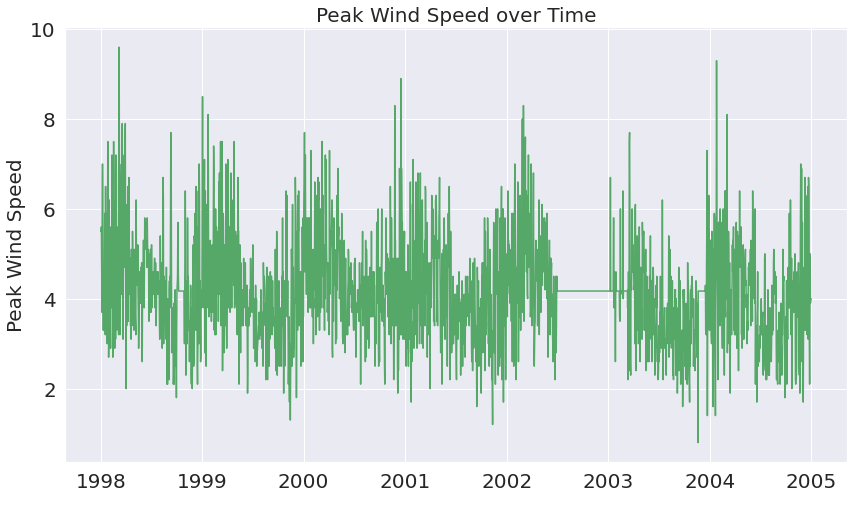

In [5]:
fig = plt.figure()
fig.set_size_inches(14, 8)
sns.set(rc={'figure.figsize':(13,8)})

b=sns.lineplot(x=df3['Date'], y=df3['WSR_PK'], color='g')

b.axes.set_title("Peak Wind Speed over Time",fontsize=20)
b.set_xlabel(" ",fontsize=15)
b.set_ylabel("Peak Wind Speed",fontsize=20)
b.tick_params(labelsize=20)

fig.savefig('wind_time.png')
print("Start date is: ", df3['Date'].min())
print("End date is: ", df3['Date'].max())

In [6]:
train, test = df3.loc[df3['Date'] <= '2003-01-30'], df3.loc[df3['Date'] > '2003-01-30']

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(train[['WSR_PK']])

train['WSR_PK'] = scaler.transform(train[['WSR_PK']])
test['WSR_PK'] = scaler.transform(test[['WSR_PK']])

<ipython-input-7-cde6d7741ab7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['WSR_PK'] = scaler.transform(train[['WSR_PK']])
<ipython-input-7-cde6d7741ab7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WSR_PK'] = scaler.transform(test[['WSR_PK']])


In [8]:
seq_size = 30  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.


def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        #print(i)
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
        #print(x_values)
        #print(y_values)
        
        
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['WSR_PK']], train['WSR_PK'], seq_size)
testX, testY = to_sequences(test[['WSR_PK']], test['WSR_PK'], seq_size)

print(trainX.shape)
print(trainY.shape)

(1804, 30, 1)
(1804,)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 214,913
Trainable params: 214,913
Non-trainable params: 0
__________________________________________________

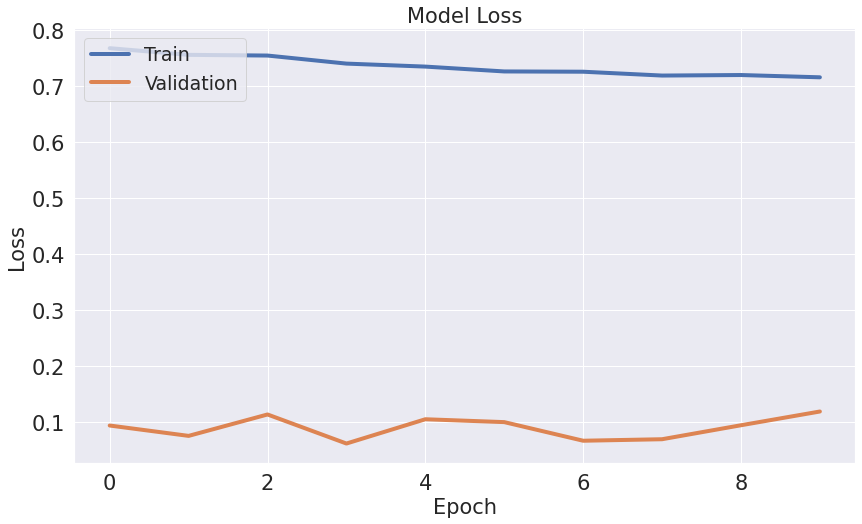

In [9]:
model = Sequential()
model.add( LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(Dropout(rate=0.2))
model.add( LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=False))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))

model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

fig = plt.figure()
fig.set_size_inches(15, 9)

plt.plot(history.history['loss'], label='Training loss' ,linewidth=4)
plt.plot(history.history['val_loss'], label='Validation loss', linewidth=4)

plt.title('Model Loss', fontsize=21)
plt.ylabel('Loss', fontsize=21)
plt.xlabel('Epoch', fontsize=21)
plt.legend(['Train', 'Validation'], loc='upper left', fontsize=19)


plt.tick_params(axis='both',labelsize=21)

fig.set_size_inches(14, 8)
fig.savefig('loss.png')



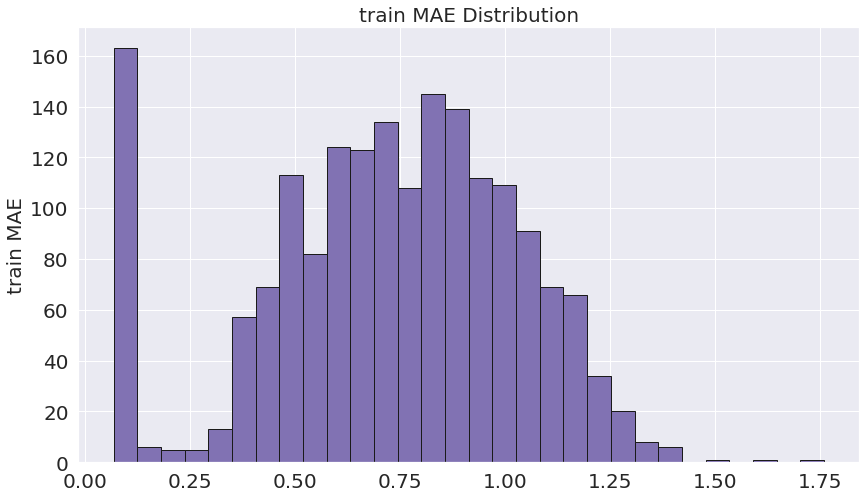

In [10]:
fig = plt.figure()
fig.set_size_inches(14, 8)

trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30, color='m', edgecolor='k')
#max_trainMAE = 0.3  #or Define 90% value of max as threshold.
plt.title('train MAE Distribution', fontsize=20)
plt.ylabel('train MAE', fontsize=20)
#plt.xlabel('Epoch', fontsize=15)

plt.tick_params(axis='both',labelsize=20)

#fig.set_size_inches(9, 5)
fig.savefig('train.png')

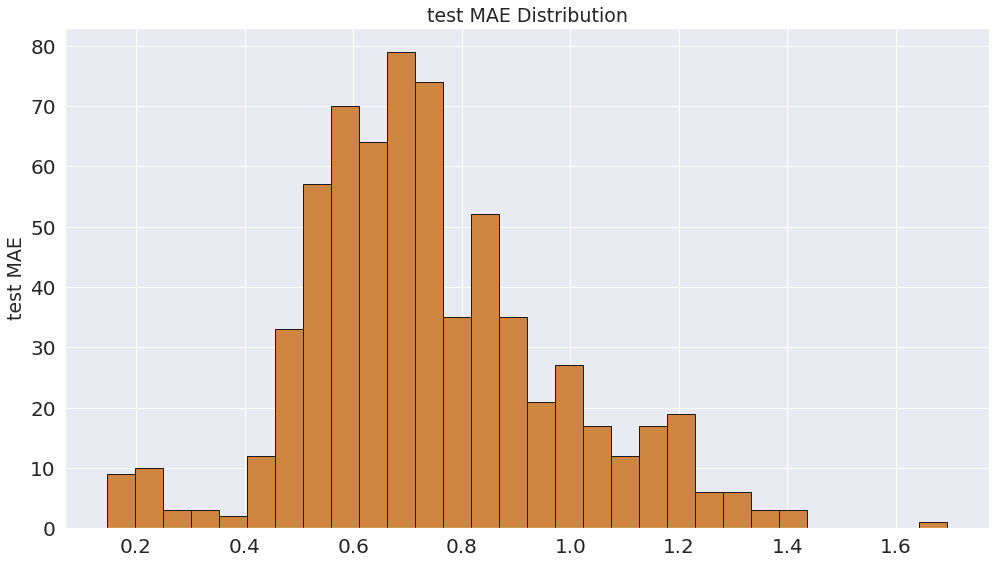

In [18]:
fig = plt.figure()
fig.set_size_inches(14, 8)

testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30, color='peru', edgecolor='k')

plt.title('test MAE Distribution', fontsize=19)
plt.ylabel('test MAE', fontsize=19)
#plt.xlabel('Epoch', fontsize=19)

plt.tick_params(axis='both',labelsize=20)

fig.tight_layout()
fig.savefig('test MAE Distribution.png')



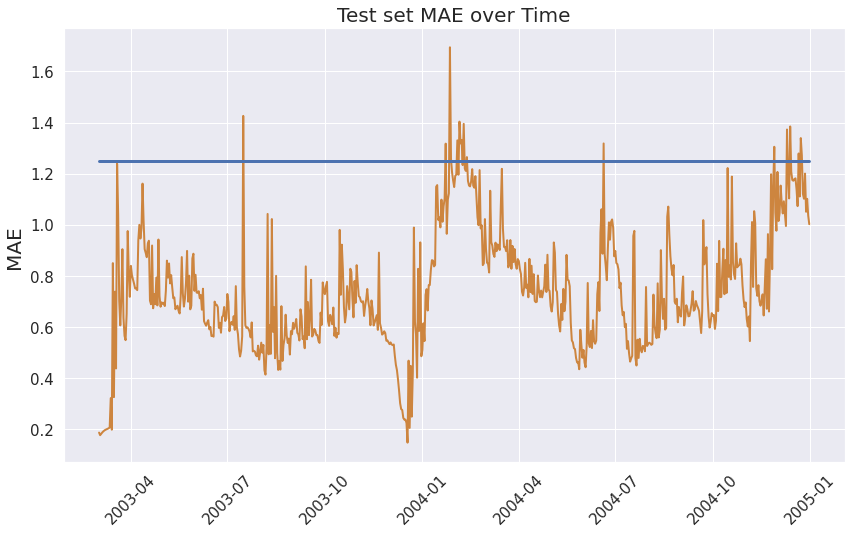

In [19]:

max_trainMAE = 1.25

#Capture all details in a DataFrame for easy plotting
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['WSR_PK'] = test[seq_size:]['WSR_PK']

#Plot testMAE vs max_trainMAE
fig = plt.figure()
fig.set_size_inches(14, 8)

sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'],linewidth=2 , color='peru')
b=sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'],linewidth=3, color='b')

for item in b.get_xticklabels():
    item.set_rotation(45)

b.axes.set_title("Test set MAE over Time",fontsize=20)
b.set_xlabel("",fontsize=20)
b.set_ylabel("MAE ",fontsize=20)

b.tick_params(labelsize=15)
#fig.legend(('')
fig.savefig('test_mae1.png')

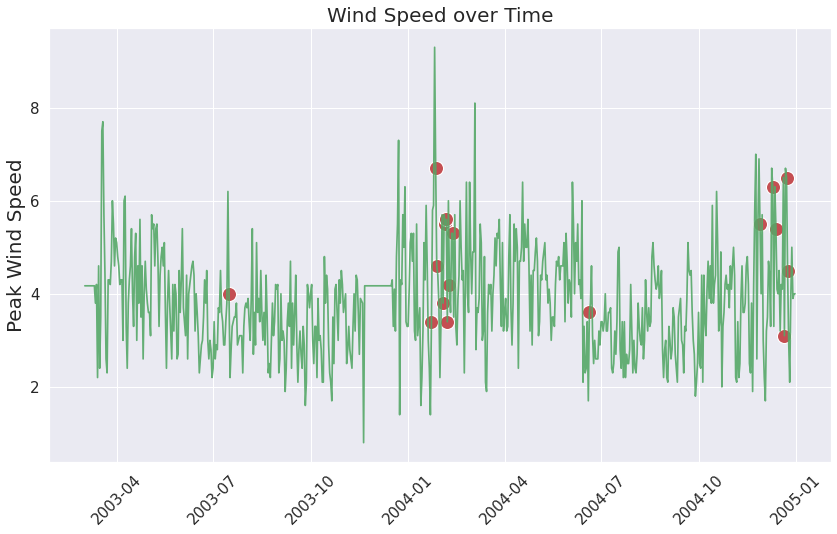

In [20]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies

fig = plt.figure()
fig.set_size_inches(14, 8)
sns.scatterplot(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['WSR_PK']), color='r', s=200)
b=sns.lineplot(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['WSR_PK']),  alpha=.9,color='g', linewidth=1.7)


for item in b.get_xticklabels():
    item.set_rotation(45)
b.axes.set_title("Wind Speed over Time",fontsize=20)
b.set_xlabel("",fontsize=20)
b.set_ylabel("Peak Wind Speed",fontsize=20)
b.tick_params(labelsize=15)


fig.savefig('marker.png')


Start date is:  1998-01-01 00:00:00
End date is:  2004-12-31 00:00:00


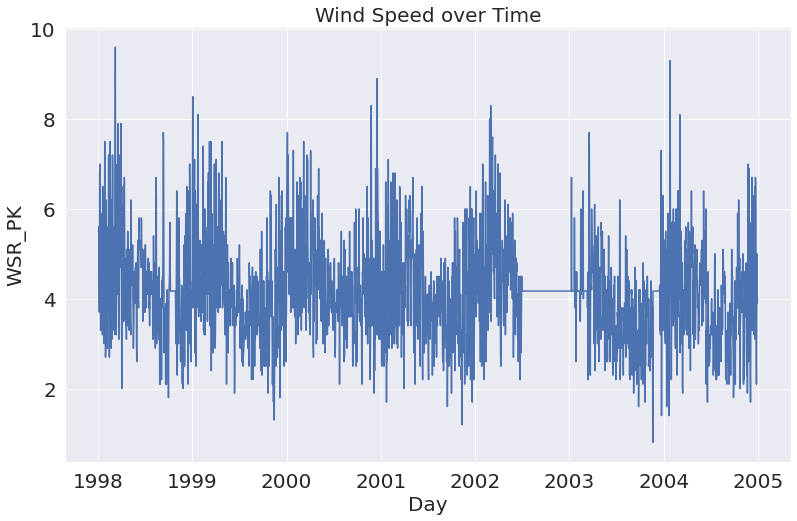

In [14]:

sns.set(rc={'figure.figsize':(13,8)})

b=sns.lineplot(x=df3['Date'], y=df3['WSR_PK'], color='b')

b.axes.set_title("Wind Speed over Time",fontsize=20)
b.set_xlabel("Day",fontsize=20)
b.set_ylabel("WSR_PK",fontsize=20)
b.tick_params(labelsize=20)


print("Start date is: ", df3['Date'].min())
print("End date is: ", df3['Date'].max())